
**Necessary Imports for Model Training and Evaluation**

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns

**Loading Data and Adding Appropriate Columns**

In [2]:
print(torch.cuda.is_available())
total_data = pd.read_csv('/content/TCGA_mirna_cancer_dataset.csv')
sra_data = pd.read_csv('/content/SRA_mirna_cancer_dataset.csv')
sra_data=sra_data.astype({'disease_type': 'int64'})
#total_data = pd.read_csv('full_miRNA_meta_dataset_normalized.csv')
total_data.replace('False', 0, inplace=True)
#case_id column is unnecessary for our purposes
total_data.drop(columns = ['case_id'], inplace = True)

# Convert meta data into the appropriate data types
total_data=total_data.astype({'disease_type': 'int64', 'gender': 'float32', 'age':'float32', 'sample_type':'int64'})



False


<ipython-input-2-6cc6db623609>:2: DtypeWarning: Columns (564) have mixed types. Specify dtype option on import or set low_memory=False.
  total_data = pd.read_csv('/content/TCGA_mirna_cancer_dataset.csv')


In [ ]:
total_data.shape

(9648, 566)

In [3]:
def transform_data(df, exclude_columns):
    data_part = df.loc[:, ~df.columns.isin(exclude_columns)]

    sum_row = data_part.sum(axis=1)
    data_part=data_part.div(sum_row, axis=0) * 1000000

    data_part = np.log(data_part+1.0)
    normalized_df=data_part


    for col in exclude_columns:
        normalized_df[col] = df[col]
    return normalized_df


In [4]:
#by modifying isin parameter, can change data used for training
#0 = primary tumor, 1 = solid normal, 2 = metastatic

train =total_data[total_data['sample_type'].isin([0,1])]

train = transform_data(train,['age','gender','disease_type','sample_type'])

#create a VALIDATION dataset --> part of tcga primary tumor samples
#set random state so that we have exact same state every time we run code
valid=train.sample(frac=0.1,random_state=200)
train=train.drop(valid.index) #remove all validation data from training set
train = train.sample(frac=1).reset_index(drop=True)
print(train.shape)

combined_test_set = total_data[total_data['sample_type'].isin([1,2])]  #solid and metastatic
#perform a log transform on combined test set and sra.
combined_test_set = transform_data(combined_test_set, ['age','gender','disease_type','sample_type'])
sra_data = transform_data(sra_data, ['disease_type'])

solid_tissue_normal = combined_test_set[combined_test_set['sample_type'].isin([1])]
metastatic = combined_test_set[combined_test_set['sample_type']==2]

features_to_keep = pd.read_csv('miRNA_SRA_features.csv')
#only keeping mirna in training for which data is available in sra
X=train[list(features_to_keep['column'])]
X.drop(columns=['disease_type'], inplace=True)
# Drop features that are not present in the other set

print("Training dataset shape")
print(X.shape)
Y= train['disease_type']

X_valid=valid[list(features_to_keep['column'])]
X_valid.drop(columns=['disease_type'], inplace=True)
# Drop features that are not present in the other set
#print(X.head())
print("Validation dataset shape")
print(X_valid.shape)
Y_valid= valid['disease_type']

X_sra = sra_data[list(features_to_keep['column'])]
X_sra.drop(columns=['disease_type'], inplace=True)
Y_sra= sra_data['disease_type']

print("SRA dataset shape")
print(X_sra.shape)



X_solid_tissue_normal = solid_tissue_normal[list(features_to_keep['column'])]
X_solid_tissue_normal.drop(columns=['disease_type'], inplace=True)
Y_solid_tissue_normal= solid_tissue_normal['disease_type']
print("Solid tissue normal data shape:", X_solid_tissue_normal.shape)


X_metastatic= metastatic[list(features_to_keep['column'])]
X_metastatic.drop(columns=['disease_type'], inplace=True)
Y_metastatic = metastatic['disease_type']
print("Metastatic tissue data shape:", X_metastatic.shape)

X_combined_test_set = combined_test_set[list(features_to_keep['column'])]
X_combined_test_set.drop(columns=['disease_type'], inplace=True)
Y_combined_test_set= combined_test_set['disease_type']
print("Combined test set shape:", X_combined_test_set.shape)

#make a pie chart of all different types of cancers present in training set
disease_labels=["Breast", "Uterus", "Ovary", "Prostate", "Testis" ,"Lung", "Kidney","Bladder","Esophagus", "Liver","Pancreas","Pleura","Colorectal",
                "Skin", "Stomach","Brain", "Cervix", "Thyroid"]
disease_count = np.zeros(len(disease_labels))
for i in range(len(disease_labels)):
    disease_count[i] = sum(Y==i)


print(len(disease_labels))
#fig, ax = plt.subplots()
#ax.pie(disease_count, labels=disease_labels,  radius = 2.8, textprops={'fontsize':14})
#plt.show()

#print(sum(disease_count))
#print(disease_count)

(8355, 566)
Training dataset shape
(8355, 497)
Validation dataset shape
(928, 497)
SRA dataset shape
(194, 497)
Solid tissue normal data shape: (633, 497)
Metastatic tissue data shape: (365, 497)
Combined test set shape: (998, 497)
18


<ipython-input-4-a62ac3adbf08>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['disease_type'], inplace=True)
<ipython-input-4-a62ac3adbf08>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid.drop(columns=['disease_type'], inplace=True)
<ipython-input-4-a62ac3adbf08>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_sra.drop(columns=['disease_type'], inplace=True)
<ipython-input-4-a62ac3adbf08>:51: SettingWit

**Function to generate ROC curve**

In [5]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc, roc_curve
from itertools import cycle
import matplotlib.pyplot as plt
import math
from sklearn.metrics import RocCurveDisplay

def plot_roc_auc_for_class(y_onehot_test, y_onehot_pred_test, labels, class_index):
  n_classes=len(labels)

  fig, ax = plt.subplots(figsize=(6, 6))
  fpr, tpr, thresholds= roc_curve(y_onehot_test[:, class_index], y_onehot_pred_test[:,class_index])
  roc_auc = auc(fpr, tpr)

  print(f"ROC AUC score:\n{roc_auc:.3f}")
  print(roc_auc)
  ax.grid()
  ax.plot(
      fpr,
      tpr,
      label=f"ROC curve (AUC = {roc_auc:.3f})",
      color="navy",
      linestyle=":",
      linewidth=4,
  )
  ax.set(title='ROC curve for metastatic skin cancer samples')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  ax.legend([f"ROC curve (AUC = {roc_auc:.3f})"])
  plt.show()

def plot_roc_curves(y_onehot_test, y_onehot_pred_test, labels):
# store the fpr, tpr, and roc_auc for all averaging strategies
  n_classes=len(labels)
  fpr, tpr, roc_auc = dict(), dict(), dict()
  thresholds=dict()
  fig, ax = plt.subplots(figsize=(6, 6))
  for i in range(n_classes):
      fpr[i], tpr[i], thresholds[i] = roc_curve(y_onehot_test[:, i], y_onehot_pred_test[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  fpr_grid = np.linspace(0.0, 1.0, 1000)

  # Interpolate all ROC curves at these points
  mean_tpr = np.zeros_like(fpr_grid)
  class_cnt=0
  for i in range(n_classes):
      if not np.isnan(tpr[i]).any(): # np.isnan(fpr[i]):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
        print(i)
        class_cnt +=1

  # Average it and compute AUC
  mean_tpr /= class_cnt

  fpr["macro"] = fpr_grid
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.3f}")
  print(roc_auc)
  ax.grid()
  plt.plot(
      fpr["macro"],
      tpr["macro"],
      color="navy",
      linestyle=":",
      linewidth=4,
  )
  ax.set(title='ROC curve for combined test set')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  ax.legend([f"macro-average ROC curve (AUC = {roc_auc['macro']:.3f})"])
  plt.show()


## Classifier Implementation

In [14]:
def call_classifier(clf_name, clf, X, Y, X_test1, Y_test1, X_test2, Y_test2, X_test3, Y_test3):

  y_pred_train = clf.predict(X)
  y_pred1 = clf.predict(X_test1)
  y_pred2 = clf.predict(X_test2)
  y_pred3 = clf.predict(X_test3)

  acc_train=metrics.accuracy_score(Y, y_pred_train)
  acc_test1=metrics.accuracy_score(Y_test1, y_pred1)
  acc_test2 = metrics.accuracy_score(Y_test2, y_pred2)
  acc_test3 = metrics.accuracy_score(Y_test3, y_pred3)

  print(clf_name, ": Accuracy on train {:.3}, solid {:.3}, metastatic {:.3} SRA {:.3}".format(acc_train, acc_test1,
                                                                                               acc_test2, acc_test3))


  conf_matrix = confusion_matrix(Y_test2, y_pred2, labels=list(range(len(disease_labels))))
  fig, ax = plt.subplots(figsize=(8,6), dpi=100)
  sns.heatmap(conf_matrix, linewidths=0, annot = True, cmap = "OrRd", xticklabels=disease_labels,
              yticklabels=disease_labels, fmt="d",cbar_kws={'label':'number of samples'})
  ax.set(xlabel="Predicted Label")
  ax.set(ylabel="True Label")
  ax.set(title='Confusion matrix on metastatic samples: ' + clf_name)


  conf_matrix = confusion_matrix(Y_test3, y_pred3, labels=list(range(len(disease_labels))))
  fig, ax = plt.subplots(figsize=(8,6), dpi=100)
  sns.heatmap(conf_matrix, linewidths=0, annot = True, cmap = "OrRd", xticklabels=disease_labels,
              yticklabels=disease_labels, fmt="d",cbar_kws={'label':'Number of Samples'})
  ax.set(xlabel="Predicted Label")
  ax.set(ylabel="True Label")
  ax.set(title='Confusion matrix on samples from SRA: ' + clf_name)

  return clf

def train_best_classifier(clf_name, X, Y, X_valid, Y_valid):
  max_acc_val = 0
  if clf_name == "Logistic Regression":
    clf = LogisticRegression(random_state=0, max_iter = 1000)
    clf = clf.fit(X,Y)
    return clf, 0

  for i in range(14, 20):
    if clf_name == "Decision Tree":
      clf = DecisionTreeClassifier(max_depth=i)
    if clf_name == "Random Forest":
      clf = RandomForestClassifier(n_estimators=128, max_depth=i)


    clf = clf.fit(X, Y)
    Y_pred_val = clf.predict(X_valid)
    acc_on_val = metrics.accuracy_score(Y_pred_val, Y_valid)
    print("accuracy with depth ", i, acc_on_val)
    if acc_on_val>max_acc_val:
      max_acc_val = acc_on_val
      best_depth = i
      best_classifier = clf



  return best_classifier, best_depth


Call classifier function on Decision Tree, Random Forest, and Logistic Regression to observe classifier performance.

In [7]:
best_decision_tree_clf, best_depth = train_best_classifier('Decision Tree', X, Y, X_valid, Y_valid)

accuracy with depth  1 0.2521551724137931
accuracy with depth  2 0.3706896551724138
accuracy with depth  3 0.47737068965517243
accuracy with depth  4 0.5280172413793104
accuracy with depth  5 0.5980603448275862
accuracy with depth  6 0.6433189655172413
accuracy with depth  7 0.7036637931034483
accuracy with depth  8 0.7370689655172413
accuracy with depth  9 0.7963362068965517
accuracy with depth  10 0.8189655172413793
accuracy with depth  11 0.8318965517241379
accuracy with depth  12 0.8351293103448276
accuracy with depth  13 0.8362068965517241
accuracy with depth  14 0.8502155172413793
accuracy with depth  15 0.8459051724137931
accuracy with depth  16 0.8351293103448276
accuracy with depth  17 0.8469827586206896
accuracy with depth  18 0.8512931034482759
accuracy with depth  19 0.8297413793103449


Decision Tree : Accuracy on train 0.994, solid 0.994, metastatic 0.625 SRA 0.345


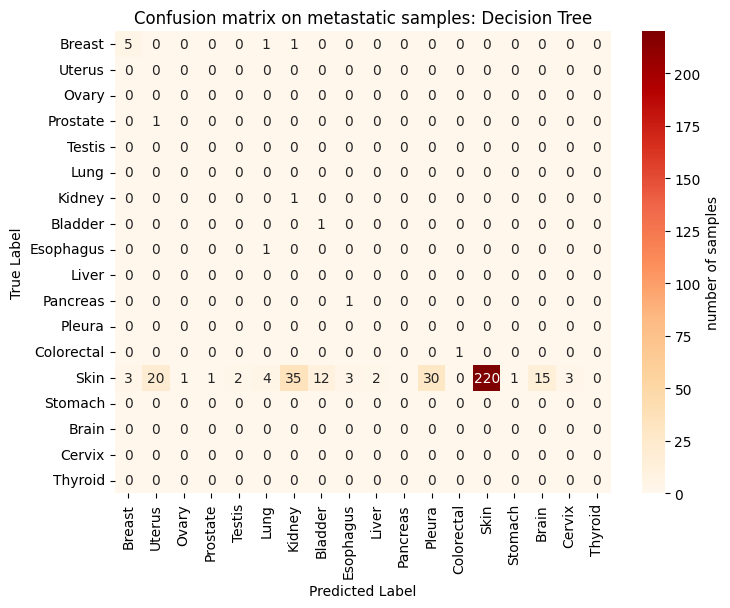

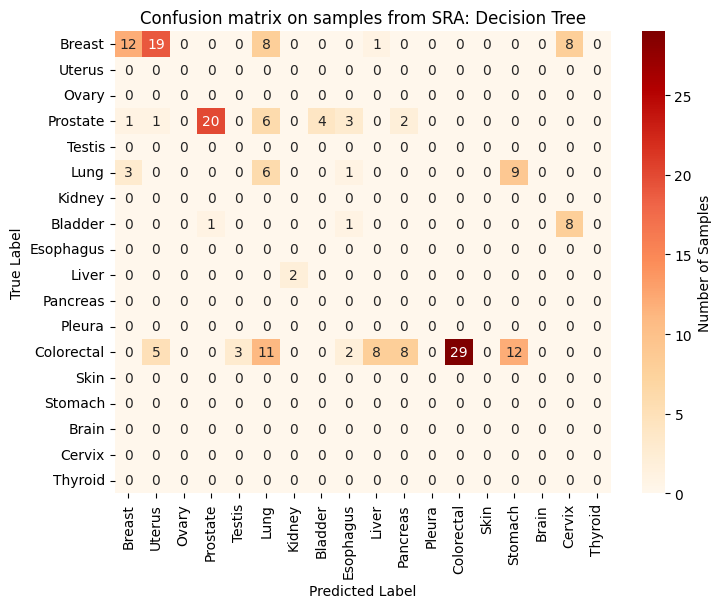

In [12]:
classifier = call_classifier("Decision Tree", best_decision_tree_clf,
X, Y, X_solid_tissue_normal, Y_solid_tissue_normal,
                             X_metastatic, Y_metastatic, X_sra, Y_sra)



accuracy with depth  14 0.9396551724137931
accuracy with depth  15 0.9504310344827587
accuracy with depth  16 0.9461206896551724
accuracy with depth  17 0.9461206896551724
accuracy with depth  18 0.9504310344827587
accuracy with depth  19 0.9504310344827587
Random Forest : Accuracy on train 1.0, solid 0.995, metastatic 0.94 SRA 0.706


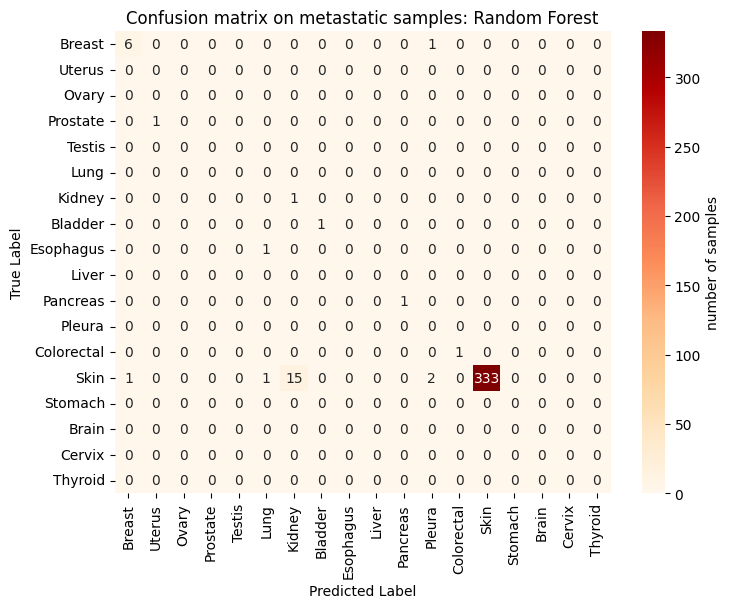

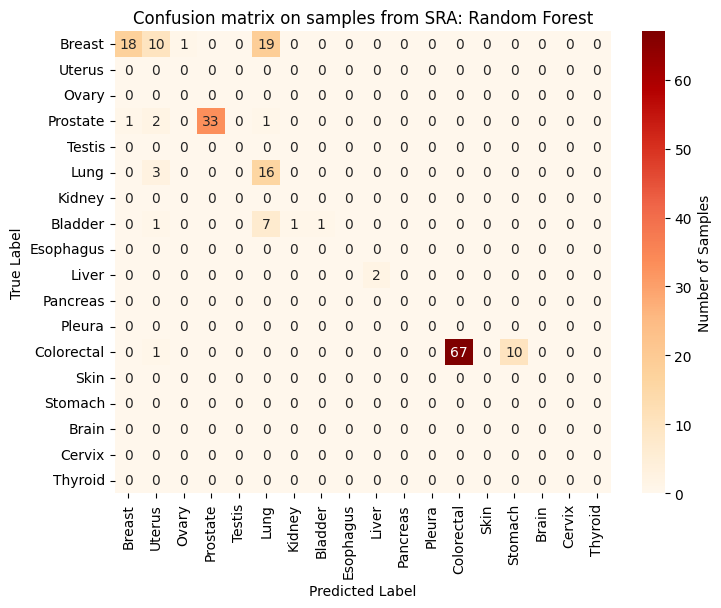

In [15]:
best_random_forest_clf, best_depth = train_best_classifier('Random Forest', X, Y, X_valid, Y_valid)
classifier = call_classifier("Random Forest", best_random_forest_clf,
X, Y, X_solid_tissue_normal, Y_solid_tissue_normal,
                             X_metastatic, Y_metastatic, X_sra, Y_sra)




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression : Accuracy on train 1.0, solid 0.998, metastatic 0.932 SRA 0.294


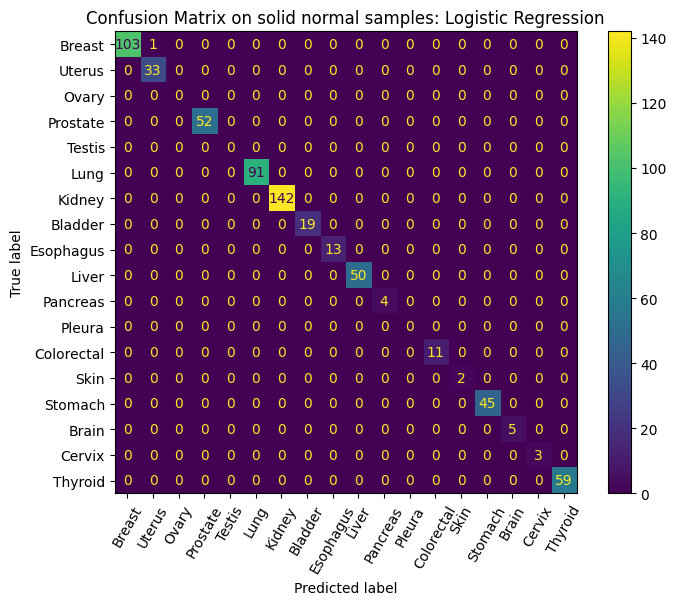

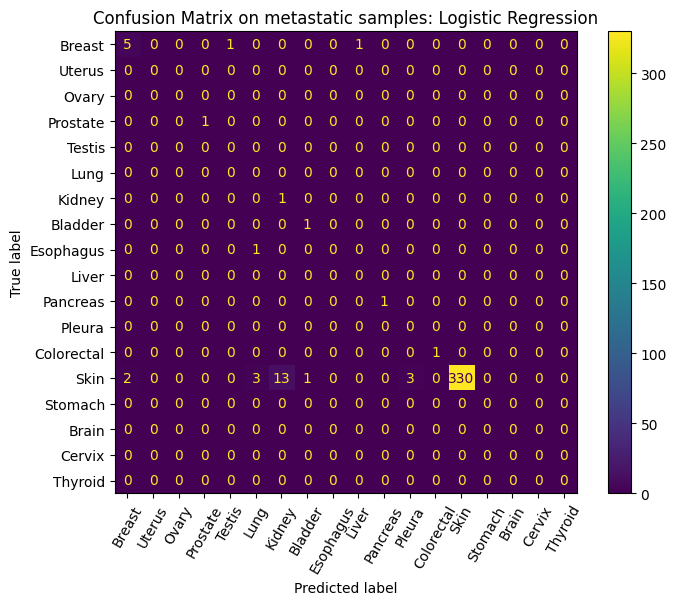

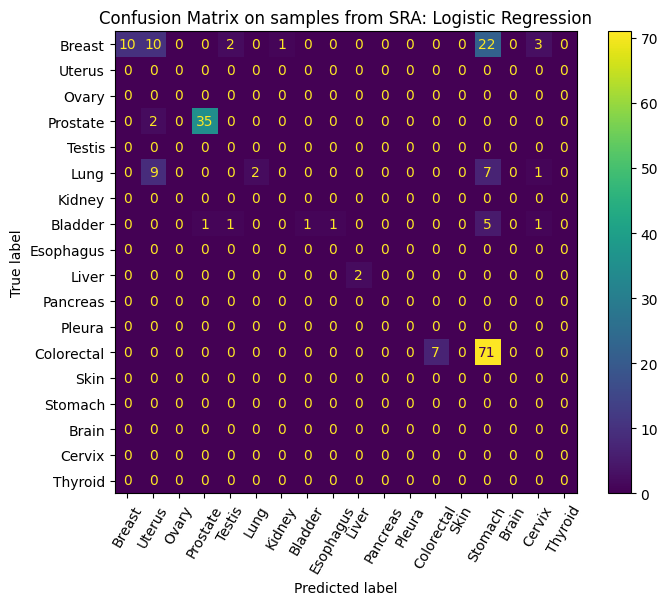

In [8]:
best_log_reg_clf, best_depth = train_best_classifier('Logistic Regression', X, Y, X_valid, Y_valid) #no hyperparameters to tune
classifier = call_classifier("Logistic Regression", best_log_reg_clf,
X, Y, X_solid_tissue_normal, Y_solid_tissue_normal,
                             X_metastatic, Y_metastatic, X_sra, Y_sra)

In [ ]:
label_binarizer = LabelBinarizer().fit(Y)
y_onehot_test = label_binarizer.transform(Y_metastatic)
y_onehot_pred_test = classifier.predict_proba(X_metastatic)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_onehot_pred_test.ravel(),
    name="micro-average OvR",
    color="darkorange",

)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on metastatic test set: Decision Tree")
plt.legend()
plt.show()
#visualize performance of model on solely metastatic skin cancer samples:
#plot_roc_auc_for_class(y_onehot_test, y_onehot_pred_test, disease_labels, 13)

#plot roc curve
#plot_roc_curves(y_onehot_test, y_onehot_pred_test, disease_labels)

In [ ]:
label_binarizer = LabelBinarizer().fit(Y)
y_onehot_test = label_binarizer.transform(Y_sra)
y_onehot_pred_test = classifier.predict_proba(X_sra)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_onehot_pred_test.ravel(),
    name="micro-average OvR",
    color="darkorange",

)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on SRA test set: Decision Tree")
plt.legend()
plt.show()
#visualize performance of model on solely metastatic skin cancer samples:
#plot_roc_auc_for_class(y_onehot_test, y_onehot_pred_test, disease_labels, 13)

#plot roc curve
#plot_roc_curves(y_onehot_test, y_onehot_pred_test, disease_labels)

## Permutation Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(classifier, X, Y,n_repeats=10, random_state=0)

In [ ]:

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
       print(f"{X.columns[i]:<8}  "
             f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


# Bar plot of importances
import pandas as pd
from matplotlib.pyplot import figure
cmap = plt.get_cmap('viridis')
colors = ['red','green','yellow'] #[cmap(i) for i in np.linspace(0, 1, len(X.columns))]
feat_importances = pd.Series(r.importances_mean, index = X.columns).sort_values(ascending = False)
feat_importances.nlargest(3).plot(kind = 'barh',color=colors)
plt.xlabel('Importance')
plt.ylabel('miRNA')


In [ ]:
cols = ['hsa-mir-10b', 'hsa-mir-584', 'hsa-mir-29c']

X2 = X.iloc[::10, :]
df1 = pd.concat([X2, X_metastatic, X_sra], axis=0)


df1.reset_index(drop=True, inplace=True)

df2 = df1.iloc[::10]
print("cols", df2.columns)
df2 = df2[cols]

df2 = df2.transpose()

ax = sns.heatmap(df2)





idx= (835 + 365)/10

ax.vlines([83, idx], *ax.get_ylim(), lw=5)

# Deep Learning Implementation

In [16]:

def predict(model, X_test_tensor, y_test_tensor):
  '''
  This function returns performance of model on a given test set
  '''

  output = model(X_test_tensor)
  output_idx = torch.argmax(output, dim=1)
  prob = torch.nn.functional.softmax(output)
  correct_cnt = torch.sum(output_idx==y_test_tensor)
  accuracy = correct_cnt/y_test_tensor.size()[0]

  return accuracy, output_idx, prob


In [17]:
#Creating class for the deep learning model
class network(nn.Module):
    def __init__(self,num_features, hidden, num_outputs, dropout):
        super(network, self).__init__()
        self.num_genes=num_features
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(self.num_genes, 2*hidden)
        self.fc2 = nn.Linear(2*hidden, hidden)



    def forward(self, x):

        y = self.dropout(x)
        y = self.fc1(y)
        y1= F.relu(y)
        y1 = self.fc2(y1)
        return y1



In [29]:
num_classes=len(disease_labels)
numRNA=X.shape[1]
dropout = 0.3
print("NUM CLASSES", num_classes)
print("NUM RNA", numRNA)
model = network(numRNA, num_classes, num_classes,dropout)

loss = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


#convert X_train, y_train, X_test, y_test to tensors
X_train_tensor = torch.tensor(X.to_numpy(),dtype=torch.float32)
y_train_tensor = torch.tensor(Y.to_numpy(),dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid.to_numpy(),dtype=torch.float32)
y_valid_tensor = torch.tensor(Y_valid.to_numpy(),dtype=torch.long)
X_sra_tensor = torch.tensor(X_sra.to_numpy(),dtype=torch.float32)
y_sra_tensor = torch.tensor(Y_sra.to_numpy(),dtype=torch.long)

X_solidnormal_tensor = torch.tensor(X_solid_tissue_normal.to_numpy(),dtype=torch.float32)
y_solidnormal_tensor = torch.tensor(Y_solid_tissue_normal.to_numpy(), dtype=torch.long)

X_metastatic_tensor = torch.tensor(X_metastatic.to_numpy(),dtype=torch.float32)
y_metastatic_tensor = torch.tensor(Y_metastatic.to_numpy(), dtype=torch.long)


#create lists to store the average losses over different epochs
train_loss_per_epoch_lst = []

acc_train_lst = []
acc_solidnormal_lst = []
acc_metastatic_lst = []

max_acc_valid = -1000


noise_scale = 0
model.train()

#TRAINING
batch_size=32
for k in range(0,50):
  loss_lst = [] #stores average losses per batch
  perm=torch.randperm(X_train_tensor.size()[0])
  X_train_tensor=X_train_tensor[perm,:]
  y_train_tensor=y_train_tensor[perm]
  for i in range(X_train_tensor.size()[0]//batch_size):

      batch_sample = X_train_tensor[batch_size*i:batch_size*(i+1),:]

      noise_sample = torch.rand(batch_sample.size())-0.5
      noise_sample = noise_sample*noise_scale # scaling the noise
      batch_sample = batch_sample+noise_sample

      batch_target = y_train_tensor[batch_size*i:batch_size*(i+1)]
      output = model(batch_sample)

      batch_loss = loss(output, batch_target)

      #calculate mean loss over batch, add to loss list
      l=torch.mean(batch_loss)
      loss_lst.append(l.detach().item())

      #back propagation - batch implementation is faster
       #calculate loss at the end of a batch
      l.backward()
      #updates the weights
      optimizer.step()
      #clear gradients of optimizer
      optimizer.zero_grad()

  avg = sum(loss_lst)/len(loss_lst)
  train_loss_per_epoch_lst.append(avg)

  #calculate performance on test set
  model.eval()
  with torch.no_grad():
    accuracy_valid,output_valid, _ = predict(model, X_valid_tensor, y_valid_tensor)
    accuracy_train,output_train,_ = predict(model, X_train_tensor, y_train_tensor)
    if max_acc_valid < accuracy_valid:
      max_acc_valid = accuracy_valid

      accuracy_solidnormal, output_solidnormal,_ = predict(model, X_solidnormal_tensor, y_solidnormal_tensor)
      accuracy_metastatic, output_metastatic,_ = predict(model, X_metastatic_tensor, y_metastatic_tensor)
      accuracy_sra, output_sra,_ = predict(model, X_sra_tensor, y_sra_tensor)

  print("Epoch {:2} train {:.3} valid {:.3} solid {:.3} meta {:.3} sra {:.3}".format(k, accuracy_train, accuracy_valid,
                                                                                          accuracy_solidnormal,
                                                                                          accuracy_metastatic, accuracy_sra))


  acc_solidnormal_lst.append(accuracy_solidnormal)
  acc_metastatic_lst.append(accuracy_metastatic)
  acc_train_lst.append(accuracy_train)
  model.train()




print(' accuracy on solid tissue set', accuracy_solidnormal)
print(' accuracy on metastatic set', accuracy_metastatic)
print(' accuracy on sra set', accuracy_sra)
print(' max validation accuracy ', max_acc_valid)

NUM CLASSES 18
NUM RNA 497


<ipython-input-16-a1031e7c5b3d>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(output)


Epoch  0 train 0.805 valid 0.8 solid 0.807 meta 0.0274 sra 0.665
Epoch  1 train 0.868 valid 0.849 solid 0.837 meta 0.816 sra 0.521
Epoch  2 train 0.906 valid 0.889 solid 0.858 meta 0.94 sra 0.572
Epoch  3 train 0.915 valid 0.894 solid 0.899 meta 0.948 sra 0.691
Epoch  4 train 0.936 valid 0.925 solid 0.902 meta 0.948 sra 0.593
Epoch  5 train 0.946 valid 0.928 solid 0.904 meta 0.94 sra 0.634
Epoch  6 train 0.946 valid 0.934 solid 0.934 meta 0.962 sra 0.747
Epoch  7 train 0.942 valid 0.93 solid 0.934 meta 0.962 sra 0.747
Epoch  8 train 0.951 valid 0.93 solid 0.934 meta 0.962 sra 0.747
Epoch  9 train 0.949 valid 0.931 solid 0.934 meta 0.962 sra 0.747
Epoch 10 train 0.963 valid 0.947 solid 0.932 meta 0.967 sra 0.701
Epoch 11 train 0.96 valid 0.944 solid 0.932 meta 0.967 sra 0.701
Epoch 12 train 0.961 valid 0.945 solid 0.932 meta 0.967 sra 0.701
Epoch 13 train 0.968 valid 0.948 solid 0.943 meta 0.975 sra 0.716
Epoch 14 train 0.959 valid 0.946 solid 0.943 meta 0.975 sra 0.716
Epoch 15 train 0









Creating a confusion matrix for deep learning model

[Text(0.5, 1.0, 'Confusion matrix on metastatic samples: Deep Learning')]

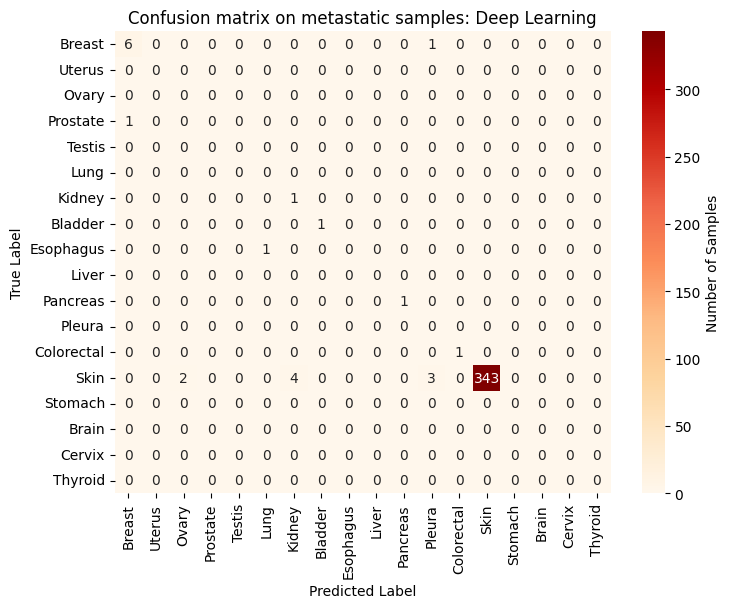

In [28]:
conf_matrix = confusion_matrix(y_metastatic_tensor, output_metastatic,labels=list(range(len(disease_labels))))
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
sns.heatmap(conf_matrix, linewidths=0, annot = True, cmap = "OrRd", xticklabels=disease_labels,
              yticklabels=disease_labels, fmt="d",cbar_kws={'label':'Number of Samples'})
ax.set(xlabel="Predicted Label")
ax.set(ylabel="True Label")
ax.set(title='Confusion matrix on metastatic samples: Deep Learning')


[Text(0.5, 1.0, 'Confusion matrix on samples from SRA: Deep Learning')]

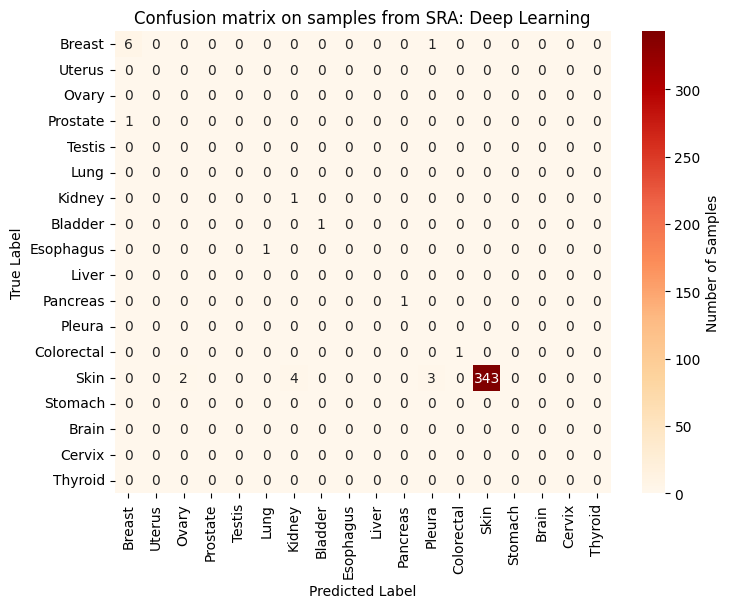

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
sns.heatmap(conf_matrix, linewidths=0, annot = True, cmap = "OrRd", xticklabels=disease_labels,
              yticklabels=disease_labels, fmt="d",cbar_kws={'label':'Number of Samples'})
ax.set(xlabel="Predicted Label")
ax.set(ylabel="True Label")
ax.set(title='Confusion matrix on samples from SRA: Deep Learning')

Create ROC curves for performance on SRA test set

In [ ]:
y_onehot_test = label_binarizer.transform(Y_sra)
_,_,y_onehot_pred_test = predict(model, X_sra_tensor , y_sra_tensor)
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_onehot_pred_test.detach().numpy().ravel(),
    name="micro-average OvR",
    color="darkorange",

)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on SRA test set: Deep Learning")
plt.legend()
plt.show()

Create ROC curves for performance on metastatic test set

In [ ]:
y_onehot_test = label_binarizer.transform(Y_metastatic)
_,_,y_onehot_pred_test = predict(model, X_metastatic_tensor , y_metastatic_tensor)
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_onehot_pred_test.detach().numpy().ravel(),
    name="micro-average OvR",
    color="darkorange",

)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on metastatic test set: Deep Learning")
plt.legend()
plt.show()